## Experiment DL learning with custom embedding
Even if the training set is too small to produce a representative word embedding, this notebook illustrates an experiment to have a rough idea on the resulting score with such embedding choice

In [1]:
import pandas as pd
import numpy as np

In [2]:
XTrain = pd.read_csv('../../data/staging_data/mispelling_fixed_clean_input_train.csv', sep=',')
YTrain = pd.read_csv('../../data/POSOS/label.csv', sep=';')

In [3]:
# hyper params
num_classes = 51
vocabulary_size = 10000
sequence_length = 30
embedding_out_dims = 400

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(XTrain['question'])

sequences = tokenizer.texts_to_sequences(XTrain['question'])
XEncodedTrain = pad_sequences(sequences, maxlen=sequence_length)

d:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Build the neural network
The NN is composed of 3 layers:
* custom embeddding layer
* LSTM layer to learn on word sequence
* fully connected layer to learn classification

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.layers.embeddings import Embedding

import tensorflow as tf
#config = tf.ConfigProto(device_count={"CPU": 32})
config = tf.ConfigProto()
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

model_lstm = Sequential()
model_lstm.add(Embedding(vocabulary_size , embedding_out_dims, input_length=sequence_length))
model_lstm.add(LSTM(embedding_out_dims, dropout=0.25, recurrent_dropout=0.25))
model_lstm.add(Dense(num_classes, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 400)           4000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dense_1 (Dense)              (None, 51)                20451     
Total params: 5,302,051
Trainable params: 5,302,051
Non-trainable params: 0
_________________________________________________________________


### Train the network

In [6]:
YOneHotEncodedTrain = keras.utils.to_categorical(YTrain['intention'])

In [7]:
import keras.utils

model_lstm.fit(XEncodedTrain, np.array(YOneHotEncodedTrain), validation_split=0.2, epochs=20)

Train on 6422 samples, validate on 1606 samples
Epoch 1/20
6422/6422 [==============================] - 17s 3ms/step - loss: 2.8018 - acc: 0.3097 - val_loss: 2.1584 - val_acc: 0.4651
Epoch 2/20
6422/6422 [==============================] - 15s 2ms/step - loss: 1.7445 - acc: 0.5439 - val_loss: 1.6531 - val_acc: 0.5897
Epoch 3/20
6422/6422 [==============================] - 15s 2ms/step - loss: 1.0814 - acc: 0.7077 - val_loss: 1.5582 - val_acc: 0.6208
Epoch 4/20
6422/6422 [==============================] - 15s 2ms/step - loss: 0.6776 - acc: 0.8127 - val_loss: 1.5577 - val_acc: 0.6314
Epoch 5/20
6422/6422 [==============================] - 15s 2ms/step - loss: 0.4258 - acc: 0.8851 - val_loss: 1.6534 - val_acc: 0.6158
Epoch 6/20
6422/6422 [==============================] - 15s 2ms/step - loss: 0.2791 - acc: 0.9229 - val_loss: 1.7660 - val_acc: 0.6171
Epoch 7/20
6422/6422 [==============================] - 15s 2ms/step - loss: 0.1832 - acc: 0.9511 - val_loss: 1.8345 - val_acc: 0.6220
Epoch 8

In [8]:
# %load "../utils/vizu.py"
import matplotlib.pyplot as plt
import itertools

def plot_keras_model_learning_curve(history):
    ''' plot accuracy of the Keras model on training and validation set '''
    plt.figure(figsize=(12,8))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')

    plt.xlabel('Predicted label')

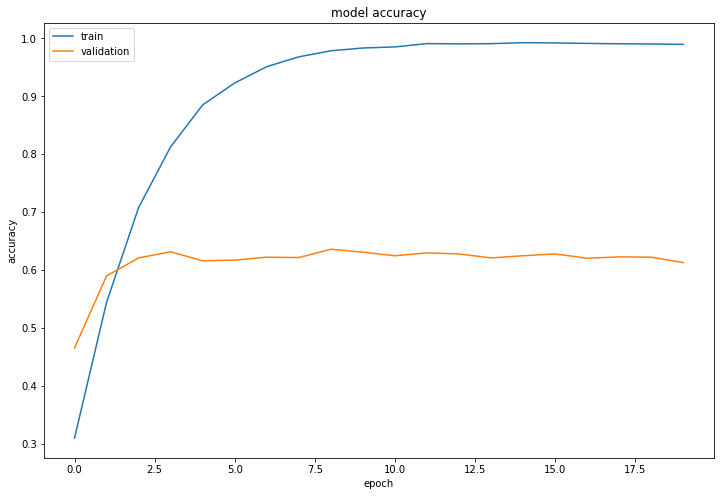

In [9]:
%matplotlib inline

plot_keras_model_learning_curve(model_lstm.history)

The model is overfitting rapidly beyond 5 epochs but no observed accuracy improvement on validation set (get rapidly stationary accuracy aounrd 62%)